In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=2b3d6ca282bc3a80ce1073224f490ac9c926c5baf5749bc8a51f00d4b5dfa29b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ren9esah
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ren9esah
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 3.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200614-cp36-none-any.whl size=41031 sha256=9bfe10f517433d7105529f7cdd979e54388d81508dc7e1e042507eaad3b5b063
  Stored in directory: /root/.cache/pip/wheels/85/83/90/8d8b68a2b79df3bbd34a9981742deacce1fcd7e3a1484ff2b5
Successfully built fvcore


In [0]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger('log_dir')

import numpy as np
import cv2
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Weapon-Detection/train_labels.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,rsz_01-06-15-110-pct-robbery-arrest.jpg,400,300,gun,72,13,186,129
1,rsz_01-06-15-110-pct-robbery-arrest.jpg,400,300,gun,189,22,302,130
2,rsz_01-06-15-110-pct-robbery-arrest.jpg,400,300,knife,94,137,209,162
3,rsz_01-06-15-110-pct-robbery-arrest.jpg,400,300,gun,216,138,327,241
4,rsz_0_hayesknives.jpg,400,300,knife,17,62,327,135


In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

def get_weapon_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['gun', 'knife']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['gun','knife']

for d in ["train", "test"]:
  DatasetCatalog.register('weapondetection/' + d, lambda d=d: get_weapon_dicts('/content/drive/My Drive/Weapon-Detection/' + d + '_labels.csv', '/content/drive/My Drive/Weapon-Detection/' + d+'/'))
  MetadataCatalog.get('weapondetection/' + d).set(thing_classes=classes)
weapon_metadata = MetadataCatalog.get('weapondetection/train')

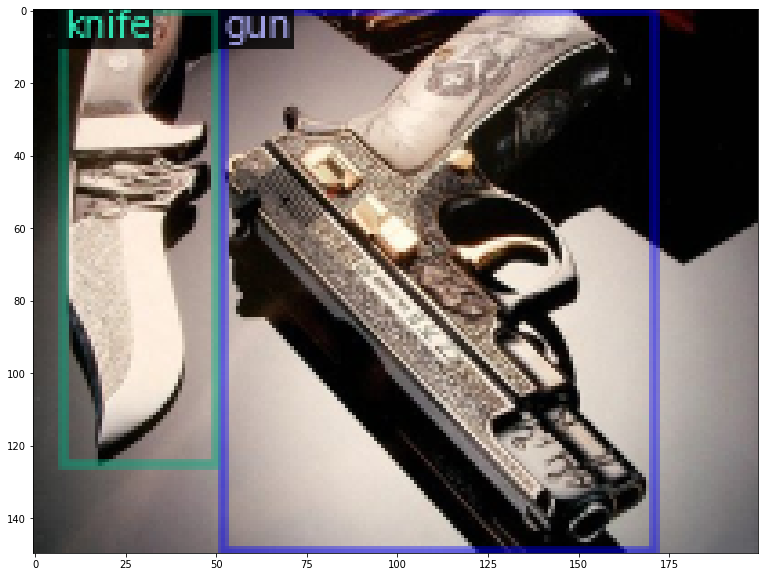

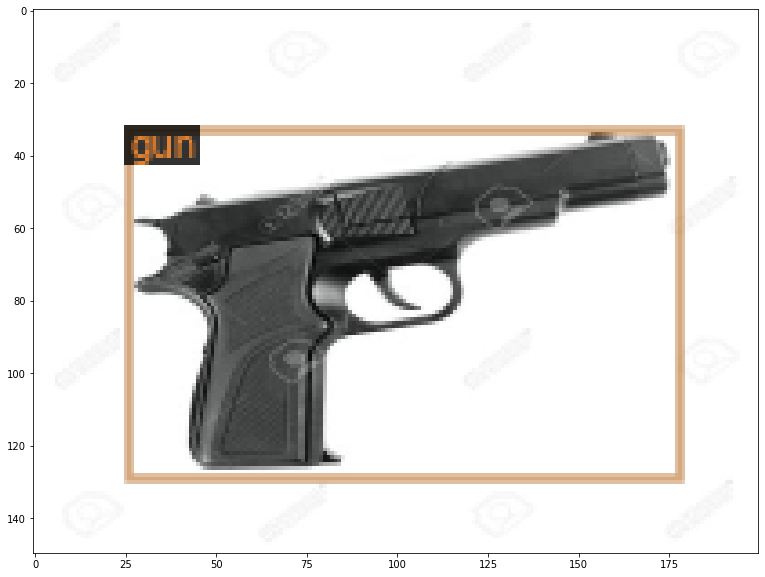

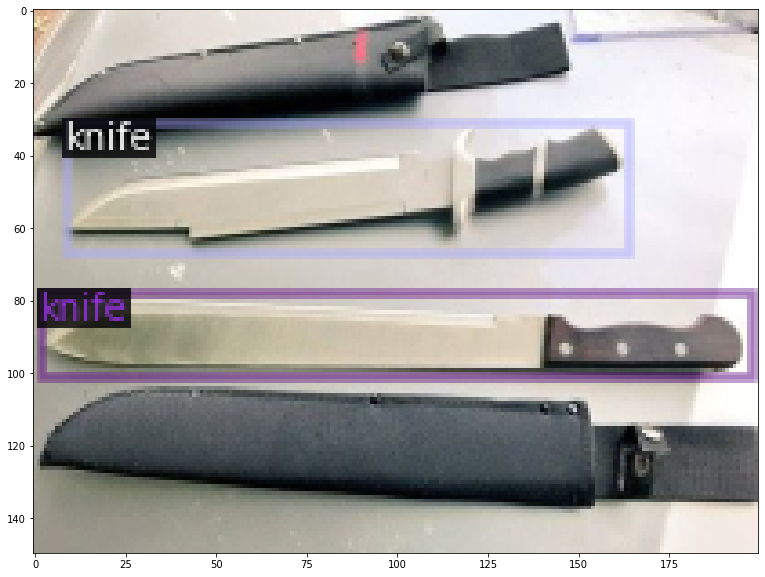

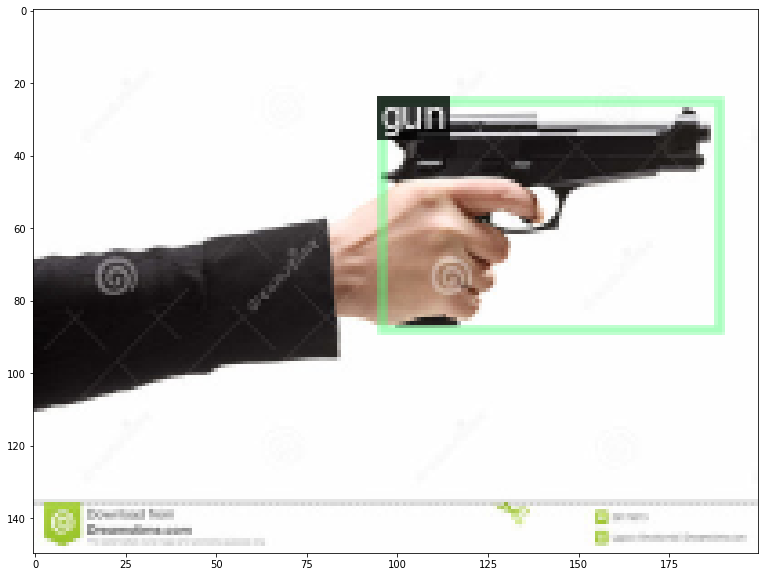

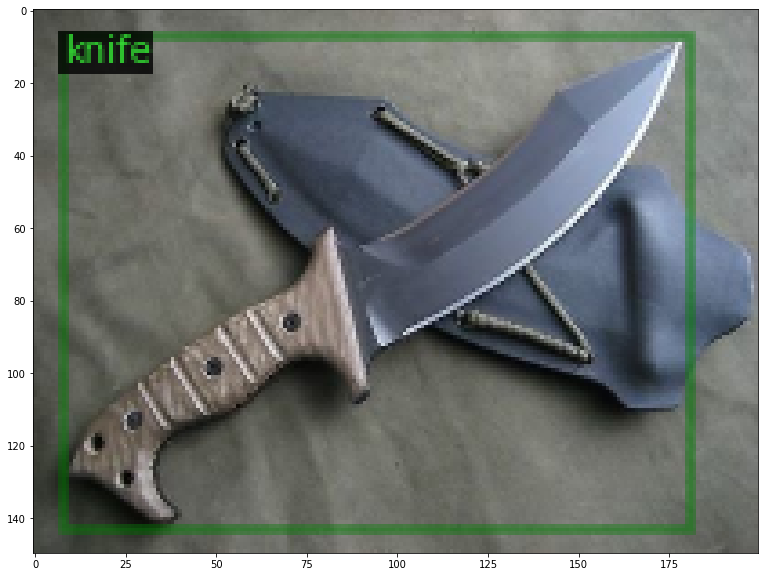

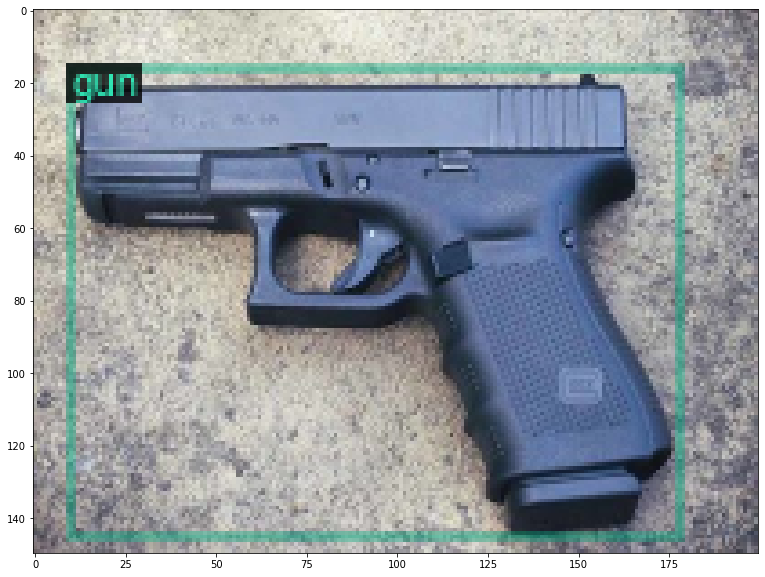

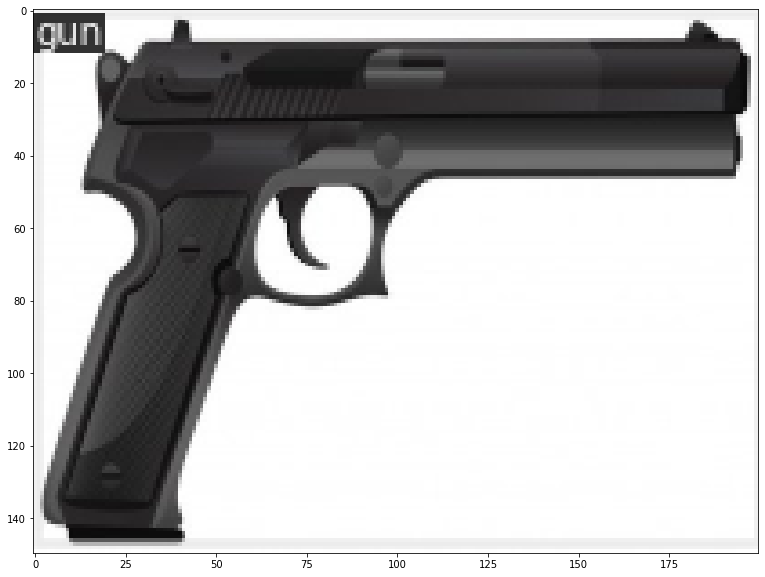

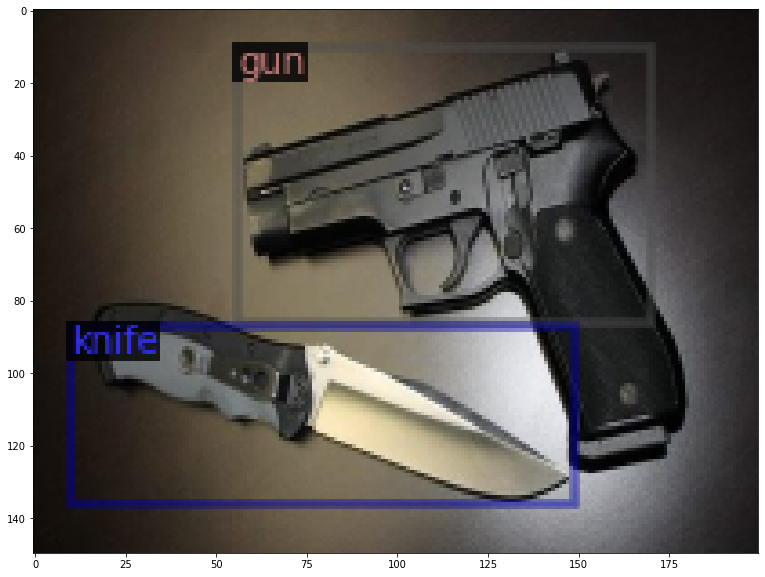

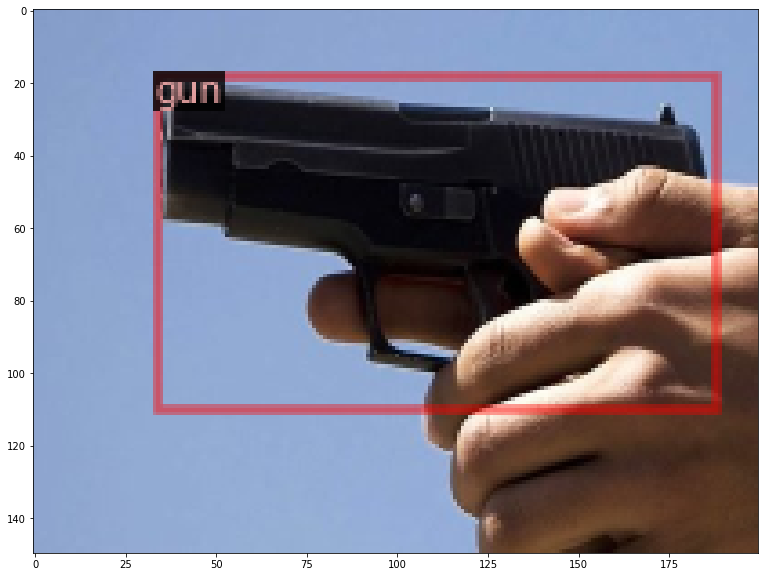

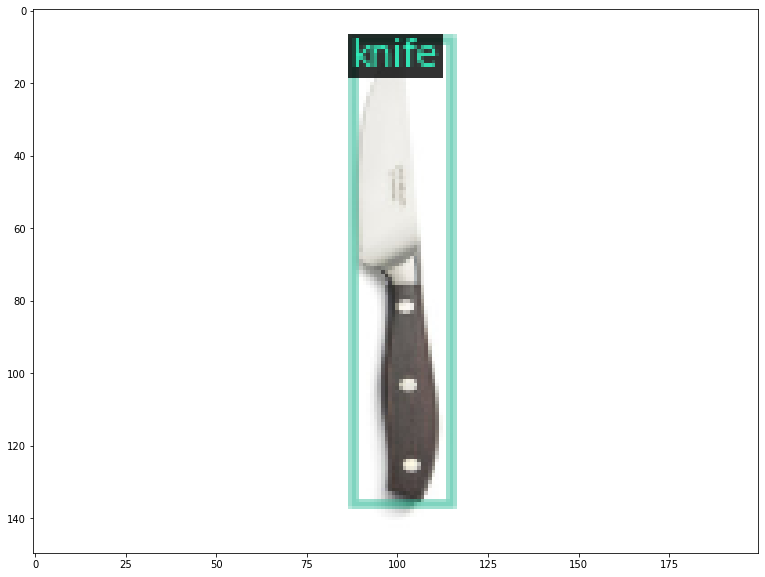

In [8]:
import random
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('weapondetection/train')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=weapon_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [9]:
cfg = get_cfg()
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ()
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (800,)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 64, 128, 256, 512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: []
    NORM: 
    OUT_CHANNELS: 256
  KEYPOINT_ON: False
  LOAD_PROPOSALS: False
  MASK_ON: False
  META_

In [10]:
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml'))
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('coco_2017_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
  

In [11]:
model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml')

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'

In [12]:
print(cfg.MODEL)

ANCHOR_GENERATOR:
  ANGLES: [[-90, 0, 90]]
  ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
  NAME: DefaultAnchorGenerator
  OFFSET: 0.0
  SIZES: [[32], [64], [128], [256], [512]]
BACKBONE:
  FREEZE_AT: 2
  NAME: build_resnet_fpn_backbone
DEVICE: cuda
FPN:
  FUSE_TYPE: sum
  IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
  NORM: 
  OUT_CHANNELS: 256
KEYPOINT_ON: False
LOAD_PROPOSALS: False
MASK_ON: False
META_ARCHITECTURE: GeneralizedRCNN
PANOPTIC_FPN:
  COMBINE:
    ENABLED: True
    INSTANCES_CONFIDENCE_THRESH: 0.5
    OVERLAP_THRESH: 0.5
    STUFF_AREA_LIMIT: 4096
  INSTANCE_LOSS_WEIGHT: 1.0
PIXEL_MEAN: [103.53, 116.28, 123.675]
PIXEL_STD: [57.375, 57.12, 58.395]
PROPOSAL_GENERATOR:
  MIN_SIZE: 0
  NAME: RPN
RESNETS:
  DEFORM_MODULATED: False
  DEFORM_NUM_GROUPS: 1
  DEFORM_ON_PER_STAGE: [False, False, False, False]
  DEPTH: 101
  NORM: FrozenBN
  NUM_GROUPS: 32
  OUT_FEATURES: ['res2', 'res3', 'res4', 'res5']
  RES2_OUT_CHANNELS: 256
  RES5_DILATION: 1
  STEM_OUT_CHANNELS: 64
  STRIDE_IN_1X1: Fal

In [0]:
cfg.DATASETS.TRAIN = ('weapondetection/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2

In [14]:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml')
cfg.MODEL.WEIGHTS

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'

In [15]:
from detectron2.engine import DefaultTrainer
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/14 12:51:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:30, 13.6MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model!


[06/14 12:52:19 d2.engine.train_loop]: Starting training from iteration 0
[06/14 12:53:23 d2.utils.events]:  eta: 0:15:11  iter: 19  total_loss: 0.788  loss_cls: 0.510  loss_box_reg: 0.117  loss_rpn_cls: 0.003  loss_rpn_loc: 0.011  time: 3.2028  data_time: 0.0170  lr: 0.000400  max_mem: 5294M
[06/14 12:54:28 d2.utils.events]:  eta: 0:14:11  iter: 39  total_loss: 0.243  loss_cls: 0.112  loss_box_reg: 0.115  loss_rpn_cls: 0.004  loss_rpn_loc: 0.011  time: 3.2326  data_time: 0.0075  lr: 0.000799  max_mem: 5294M
[06/14 12:55:32 d2.utils.events]:  eta: 0:12:57  iter: 59  total_loss: 0.233  loss_cls: 0.084  loss_box_reg: 0.139  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 3.2266  data_time: 0.0071  lr: 0.001199  max_mem: 5294M
[06/14 12:56:40 d2.utils.events]:  eta: 0:12:06  iter: 79  total_loss: 0.197  loss_cls: 0.068  loss_box_reg: 0.123  loss_rpn_cls: 0.001  loss_rpn_loc: 0.007  time: 3.2624  data_time: 0.0066  lr: 0.001598  max_mem: 5294M
[06/14 12:57:44 d2.utils.events]:  eta: 0:11:0

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ('weapondetection/test', )

In [17]:
predictor = DefaultPredictor(cfg)
predictor

In [18]:
print(cfg.DATASETS)

PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
PROPOSAL_FILES_TEST: ()
PROPOSAL_FILES_TRAIN: ()
TEST: ('weapondetection/test',)
TRAIN: ('weapondetection/train',)


In [19]:
print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))

Metadata(name='weapondetection/train', thing_classes=['gun', 'knife'])


In [20]:
df_test = pd.read_csv('/content/drive/My Drive/Weapon-Detection/test_labels.csv')
df_test

,filename,width,height,class,xmin,ymin,xmax,ymax
0,rsz_image-asset.jpg,400,300,gun,1,4,399,294
1,rsz_image-asset_1.jpg,400,300,gun,1,1,399,297
2,rsz_image-asset_2.jpg,400,300,gun,49,30,318,299
3,rsz_img_5717.jpg,400,300,knife,50,53,364,265
4,rsz_istockphoto-940433760-640x640.jpg,400,300,knife,133,40,298,297
5,rsz_kn700-neuro-knife-titanium.jpg,400,300,knife,110,11,188,290
6,rsz_kn700-neuro-knife-titanium.jpg,400,300,knife,213,12,291,278
7,rsz_knife-in-burglary.jpg,400,300,knife,37,152,247,204
8,rsz_primary.jpg,400,300,gun,1,61,399,238
9,rsz_python.jpg,400,300,gun,19,84,397,255


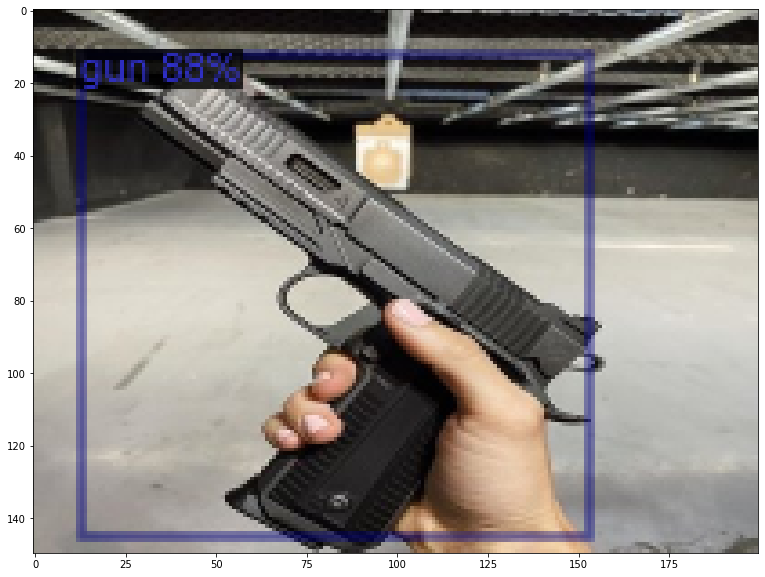

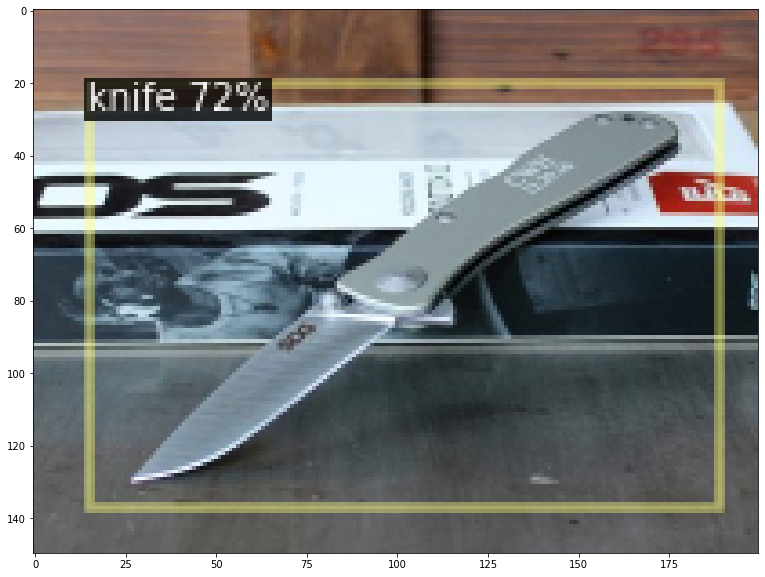

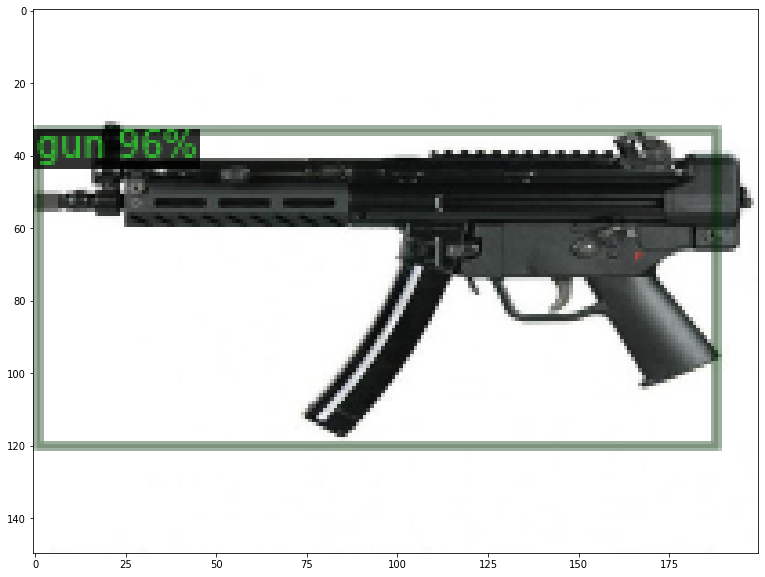

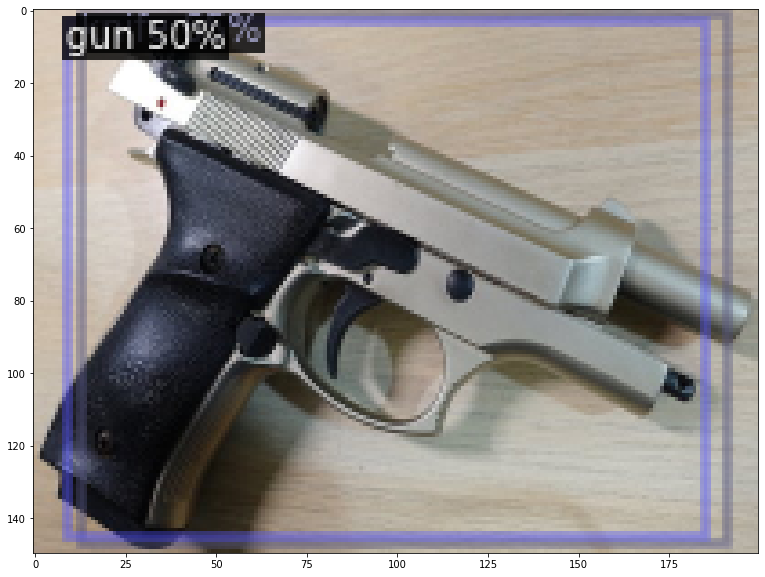

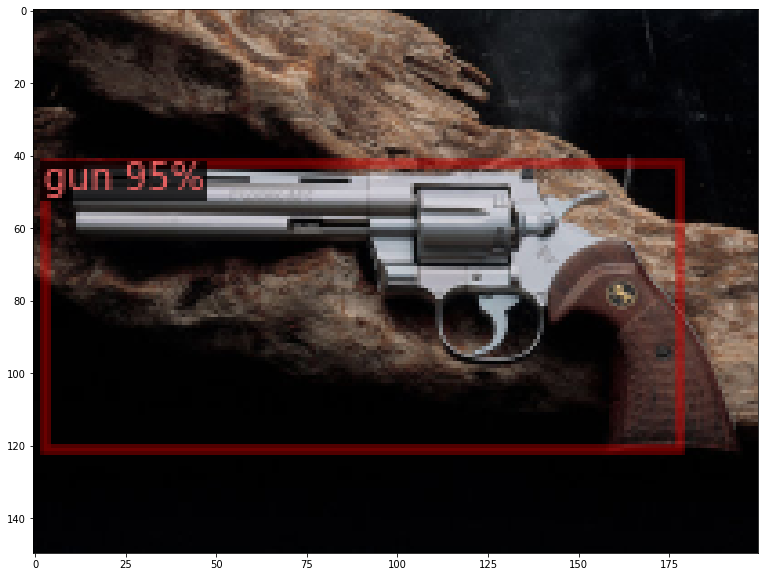

In [21]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('weapondetection/test')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=weapon_metadata, scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

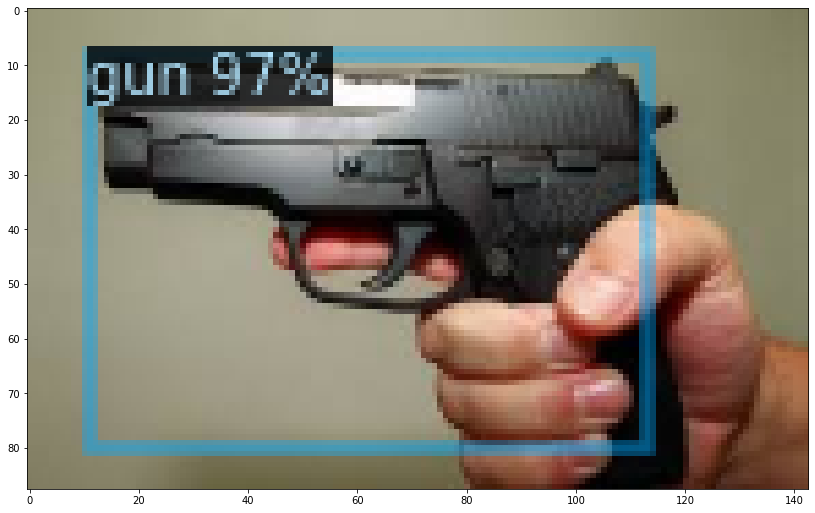

In [23]:
from detectron2.utils.visualizer import ColorMode
import random


dataset_dicts = DatasetCatalog.get('weapondetection/test')   
im = cv2.imread("input.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=weapon_metadata, scale=0.5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()